In [1]:
!pip install transformers
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.2 MB/s eta 0:00:00


In [2]:
!pip install seaborn
!pip install matplotlib
!pip install textwrap

ERROR: Could not find a version that satisfies the requirement textwrap (from versions: none)
ERROR: No matching distribution found for textwrap


In [3]:
!pip install sklearn

  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post7-py3-none-any.whl size=2952 sha256=159f2af59a1fb820cac13efe84cccb10e6eb465e54a3f15aaf2bea85effb70cc
  Stored in directory: /root/.cache/pip/wheels/c8/9c/85/72901eb50bc4bc6e3b2629378d172384ea3dfd19759c77fd2c
Successfully built sklearn


In [4]:
from transformers import pipeline

from datasets import load_dataset
import torch
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import textwrap

from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

In [5]:
!nvcc --version
device = torch.device(0 if torch.cuda.is_available() else "cpu")
print(device)
X_train = torch.FloatTensor([0., 1., 2.])
X_train = X_train.to(device)
X_train.is_cuda

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
cuda:0


True

In [6]:
torch.cuda.device_count()

1

In [7]:
classifier = pipeline('zero-shot-classification', device=device)

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [8]:
dataset = load_dataset('solomonk/reddit_mental_health_posts')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/solomonk___csv/solomonk--reddit_mental_health_posts-ebd98f1303b315a0/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
data = dataset['train']
df = pd.DataFrame(data)

In [10]:
df = df[~df.apply(lambda row: row.astype(str).str.contains('deleted').any(), axis=1)]
df = df[~df.apply(lambda row: row.astype(str).str.contains('removed').any(), axis=1)]
df = df[['body','subreddit']]

In [11]:
len(df)

84185

In [12]:
df.sample(frac=1).head()

,body,subreddit
118645,"I posted about this a little while ago, but I ...",OCD
25266,I am on a low dose of Vyvanse. I happen to hav...,ADHD
131717,I’m been getting these random images flashing ...,ptsd
90207,Sometimes ocd will be going through my head an...,OCD
10511,It kicked in a 2am for me and I had to get up ...,ADHD


In [13]:
labels = list(set(df['subreddit']))
labels

['aspergers', 'OCD', 'ptsd', 'depression', 'ADHD']

In [14]:
print(textwrap.fill(df.iloc[8]['body']))

TL;DR - rough time titrating on concerta for the last two months, each
dose either fizzled out, made me exhausted/zoned out and angry, but
generally it's great for my symptoms. Feeling really disheartened, if
in a similar boat, what worked for you in the end/do you have any
advice?    So I've been titrating up on concerta for about two months,
currently coming to the end of my 36mg.   - 18mg worked wonders the
first day, then slowly went more to the background as time went on,
and the benefit was kind of unnoticeable.   - 27mg again felt very
calming and focusing on the first day, felt like it was my dose, but
then as the two weeks went on I felt incredibly tired, zoned out,
couldn't keep my eyes open etc., they worked for my symptoms but
otherwise felt awful, like I'd had no sleep.   - 36mg then came along
and holy crap, first day I felt extreme anxiety/anger, and I would
hyperfocus on thoughts resulting in me taking nothing in people said
to me. This did eventually level out as the m

In [15]:
df.iloc[8]['subreddit']

'ADHD'

In [16]:
df =df.dropna()
df

,body,subreddit
0,A few months ago I was accepted into this full...,ADHD
1,"Hey guys, I was curious if anyone else has the...",ADHD
2,\n\ni have 6 exams in the next 2 weeks one of...,ADHD
3,Is there anyone out there that is struggling w...,ADHD
4,"Whenever I get hungry, I never eat because I d...",ADHD
...,...,...
151277,Do ppl with PTSD also get paranoia like BPD ( ...,ptsd
151282,"On the 4th of July, I got really intoxicated a...",ptsd
151283,The rescheduling and the waiting and the sheer...,ptsd
151284,"I experienced a stressful, drawn out event rec...",ptsd


In [17]:
df = df.sample(frac=1, random_state=2023)
print(df.head)
df = df[0:15000]
df.head

<bound method NDFrame.head of                                                      body   subreddit
136174   I've been meaning to use a notebook to write ...        ptsd
105286  I’m really struggling this month. It’s tearing...         OCD
91998     \nHello, I’m writing this because I need to ...         OCD
87008   I am currently diagnosed with GAD and OCD a co...         OCD
141040  “Healing from trauma can also mean strength an...        ptsd
...                                                   ...         ...
71417   i’ve been waiting for it to get better like ev...  depression
70361   I have been really depressed since I was aroun...  depression
92619   I have been feeling happy recently, not amazin...         OCD
85925   Ok, I've discovered that there was such a thin...         OCD
40233   Ignoring the pros that come with having a fat ...   aspergers

[82665 rows x 2 columns]>


<bound method NDFrame.head of                                                      body subreddit
136174   I've been meaning to use a notebook to write ...      ptsd
105286  I’m really struggling this month. It’s tearing...       OCD
91998     \nHello, I’m writing this because I need to ...       OCD
87008   I am currently diagnosed with GAD and OCD a co...       OCD
141040  “Healing from trauma can also mean strength an...      ptsd
...                                                   ...       ...
86434   That probably made very little sense, but it d...       OCD
96117       Here's why: https://www.ocduk.org/ocd/pure-o/       OCD
5554    Hello!  My son was just diagnosed with ADHD co...      ADHD
111527  It's the first time I've actually tried to get...       OCD
27551   I’ve always been a hyper sensitive child, afte...      ADHD

[15000 rows x 2 columns]>

In [18]:
classifier(df.iloc[8]['body'], candidate_labels=labels)

{'sequence': "He did something wrong. Something very wrong that he hid for me for a year and a half. Without going into too much detail, I've had feelings for him for a while and he knew. We still remain best friends because we honestly believe we are soulmates, whether we're together or not. I found out about what he did 3 weeks ago and have been working through it ever since.\n\nThen something happened today with someone else and I spent the entire day going from happy, numb to sad. It was a mess and I told my friend about it, and he started feeling extremely guilty for what he did, even though I wasn't trying to blame him or anything (these were two separate problems, but similar enough to basically be tied into each other). He's just not great at giving me the answers I need or expect, and everything just seems to confuse or overwhelm him to the point where he doesn't know what to say anymore, and he started hating himself over it (I've always been the communicative one, and have d

In [19]:
preds = classifier(df['body'].tolist(), candidate_labels=labels)

In [20]:
preds

[{'sequence': ' I\'ve been meaning to use a notebook to write down what traumas I\'ve endured just to get them out of my head. The thing is I feel almost like I\'m doing something I\'m not supposed to. As if I am over reacting to things in my past that "aren\'t a big deal" because thats what I\'ve been told.. I\'m so tired of keeping everything bottled up to the point I have a huge breakdown when unwanted memories flood in. It\'s like I\'m reliving them over and over... The past two weeks have been hell mentally because something that happened in my childhood resurfaced to my memory and has traumatized me all over again. I\'ve only managed to get a page in and I haven\'t even covered the first trauma I\'ve endured. I\'m thinking about just finding the right place to post instead of journaling on physical paper. I\'m too afraid of it getting in the wrong person(s) hands and then being judged and misunderstood.',
  'labels': ['ptsd', 'depression', 'aspergers', 'OCD', 'ADHD'],
  'scores':

In [21]:
predicted_labels = [d['labels'][0] for d in preds]

In [22]:
df['predicted_labels'] = predicted_labels

In [23]:
print('Acc:', np.mean(df['predicted_labels'] == df['subreddit']))

Acc: 0.5401333333333334


In [24]:
# Convert prediction probs into an NxK matrix according to
# original label order

N = len(df)
K = len(labels)
label2idx = {v:k for k, v in enumerate(labels)}

probs = np.zeros( (N, K) )
for i in range(N) :
  # loop through labels and scores in corresponding order
  d = preds[i]
  for label, score in zip(d['labels'], d['scores']):
    k = label2idx[label]
    probs[i, k] = score

In [25]:
int_labels = [label2idx[x] for x in df['subreddit']]

In [26]:
int_preds = np.argmax(probs, axis=1)
cm =confusion_matrix(int_labels, int_preds, normalize='true')

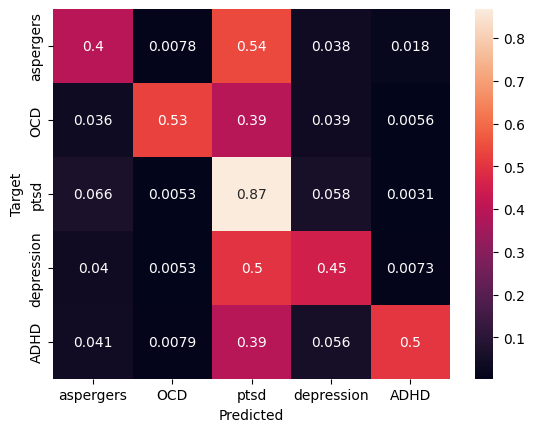

In [27]:
# Scikit—Learn is transitioning to VI but it's not available on Colab
# The changes modify how confusion matrices are plotted
def plot_cm(cm):
  df_cm = pd.DataFrame(cm, index=labels, columns=labels)
  ax = sn.heatmap(df_cm, annot=True, fmt='.2g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")
plot_cm (cm)

In [28]:
f1_score(df['subreddit'] , predicted_labels, average='micro')

0.5401333333333334

In [29]:
roc_auc_score(int_labels, probs, multi_class='ovo')

0.8566641179258646